In [ ]:
pip install gym numpy

Episode 1 (Epsilon-Greedy): Total Reward = -133, Steps = 56
Episode 1 (UCB): Total Reward = -6, Steps = 7
Episode 1 (Hybrid): Total Reward = -5, Steps = 6
Episode 2 (Epsilon-Greedy): Total Reward = -4, Steps = 5
Episode 2 (UCB): Total Reward = -5, Steps = 6
Episode 2 (Hybrid): Total Reward = -1, Steps = 2
Episode 3 (Epsilon-Greedy): Total Reward = -1, Steps = 2
Episode 3 (UCB): Total Reward = -28, Steps = 9
Episode 3 (Hybrid): Total Reward = -26, Steps = 7
Episode 4 (Epsilon-Greedy): Total Reward = -23, Steps = 4
Episode 4 (UCB): Total Reward = -33, Steps = 14
Episode 4 (Hybrid): Total Reward = -28, Steps = 9
Episode 5 (Epsilon-Greedy): Total Reward = -48, Steps = 21
Episode 5 (UCB): Total Reward = -40, Steps = 21
Episode 5 (Hybrid): Total Reward = -6, Steps = 7
Episode 6 (Epsilon-Greedy): Total Reward = -6, Steps = 7
Episode 6 (UCB): Total Reward = -114, Steps = 37
Episode 6 (Hybrid): Total Reward = -28, Steps = 9
Episode 7 (Epsilon-Greedy): Total Reward = -2, Steps = 3
Episode 7 (UCB

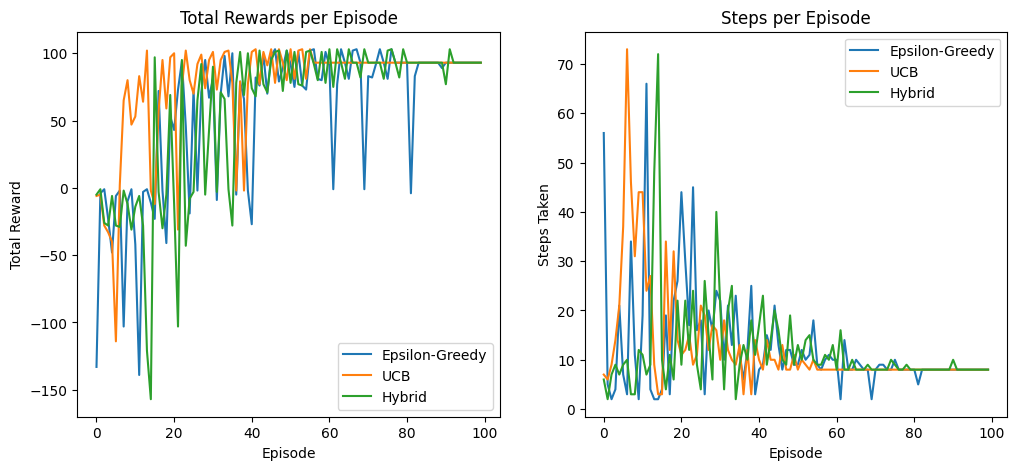

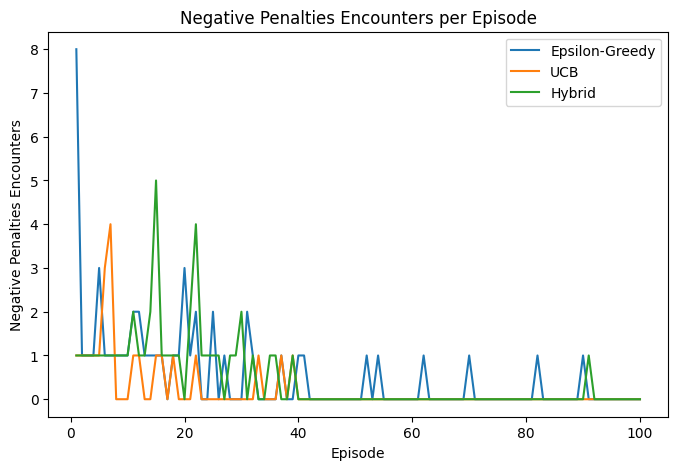

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class MazeEnvironment(gym.Env):
    def __init__(self, exploration_strategy='epsilon_greedy'):
        super(MazeEnvironment, self).__init__()

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((spaces.Discrete(5), spaces.Discrete(5)))

        self.initialize_maze()

        self.q_table = np.zeros((25, 4))  # 25 states and 4 actions
        self.epsilon = 1.0  # Initial exploration rate for epsilon-greedy
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.alpha = 0.1  # Initial learning rate
        self.gamma = 0.99  # Discount factor
        self.last_episode_steps = np.inf  # Track steps of the last episode
        self.threshold_nse = 50  # Threshold for NSE mitigation
        self.nse_encounter_count = 0  # Counter for NSE encounters
        self.nse_encounters = []  # Track NSE encounters per episode
        self.exploration_strategy = exploration_strategy  # Exploration strategy: 'epsilon_greedy' or 'ucb'
        self.ucb_c = 1.25

    def initialize_maze(self):
        self.goal_state = (4, 4)
        self.start_state = (0, 0)
        self.agent_position = self.start_state
        self.forbidden_zones = {(1, 1), (1, 2)}
        self.blocked_paths = {(2, 2), (3, 2)}
        self.step_penalty_threshold = 10
        self.steps_taken = 0
        self.total_reward = 0

        self.maze = np.zeros((5, 5), dtype=str)
        for r in range(5):
            for c in range(5):
                self.maze[r, c] = '.'
        self.maze[self.goal_state] = 'G'
        for fz in self.forbidden_zones:
            self.maze[fz] = 'F'
        for bp in self.blocked_paths:
            self.maze[bp] = 'B'

    def reset(self):
        self.agent_position = self.start_state
        self.steps_taken = 0
        self.total_reward = 0
        self.update_maze_position(self.start_state, self.agent_position)
        return self.state_to_index(self.agent_position)

    def state_to_index(self, state):
        return state[0] * 5 + state[1]

    def step(self, action):
        if self.exploration_strategy == 'epsilon_greedy' and np.random.random() < self.epsilon:
            action = self.action_space.sample()

        next_state = list(self.agent_position)
        if action == 0 and next_state[0] > 0: next_state[0] -= 1
        elif action == 1 and next_state[0] < 4: next_state[0] += 1
        elif action == 2 and next_state[1] > 0: next_state[1] -= 1
        elif action == 3 and next_state[1] < 4: next_state[1] += 1

        next_state = tuple(next_state)
        reward, done = self.calculate_reward(next_state)
        self.total_reward += reward
        self.steps_taken += 1

        current_index = self.state_to_index(self.agent_position)
        next_index = self.state_to_index(next_state)
        best_future_reward = np.max(self.q_table[next_index])

        # Implement UCB exploration strategy
        if self.exploration_strategy == 'ucb':
            if np.sum(self.q_table[current_index]) > 0:
              exploration_bonus = self.ucb_c * np.sqrt(np.log(self.steps_taken + 1) / np.sum(self.q_table[current_index]))
            else:
              exploration_bonus = self.ucb_c * np.sqrt(np.log(self.steps_taken + 1) / 1e-6)

            ucb_q_values = self.q_table[current_index] + exploration_bonus
            action_ucb = np.argmax(ucb_q_values)

            if np.random.random() < self.epsilon:
                action = action_ucb

        self.q_table[current_index, action] += self.alpha * (reward + self.gamma * best_future_reward - self.q_table[current_index, action])

        self.update_maze_position(self.agent_position, next_state)
        self.agent_position = next_state

        if done:
            if self.exploration_strategy == 'epsilon_greedy':
                self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            elif self.exploration_strategy == 'ucb':
                # No need to update epsilon for UCB strategy
                pass

            if self.steps_taken > self.last_episode_steps:
                self.total_reward -= 10  # Penalty for more steps
            elif self.steps_taken < self.last_episode_steps:
                self.total_reward += 10  # Reward for fewer steps
            self.last_episode_steps = self.steps_taken  # Update last episode steps

            if self.total_reward < -self.threshold_nse:
                self.total_reward -= 50  # Additional penalty for exceeding NSE threshold

            self.nse_encounters.append(self.nse_encounter_count)
            self.nse_encounter_count = 0  # Reset NSE encounter count for next episode

        return self.state_to_index(next_state), reward, done, {}

    def calculate_reward(self, next_state):
        if next_state in self.forbidden_zones:
            self.nse_encounter_count += 1
            return -10, True
        elif next_state in self.blocked_paths:
            self.nse_encounter_count += 1
            return -5, False
        elif next_state == self.goal_state:
            return 100, True
        elif self.steps_taken % self.step_penalty_threshold == 0:
            self.nse_encounter_count += 0
            return -1, False
        return -1, False

    def update_maze_position(self, old_pos, new_pos):
        self.maze[old_pos] = '.'
        self.maze[new_pos] = 'A'

    def render(self, mode='human'):
        print("\n".join(["".join(row) for row in self.maze]))

class HybridMazeEnvironment(MazeEnvironment):
    def __init__(self):
        super(HybridMazeEnvironment, self).__init__()
        self.ucb_c = 1.25  # UCB exploration parameter
        # Initialize separate Q-tables for Epsilon-Greedy and UCB strategies
        self.q_table_greedy = np.zeros((25, 4))  # Q-table for epsilon-greedy
        self.q_table_ucb = np.zeros((25, 4))  # Q-table for UCB
        self.epsilon_greedy_epsilon = 1.0
        self.epsilon_greedy_decay = 0.95
        self.alpha=0.1
        self.gamma = 0.99


def step(self, action):
    current_index = self.state_to_index(self.agent_position)

    # Compute the next state based on the action taken
    next_state = list(self.agent_position)
    if action == 0 and next_state[0] > 0:
        next_state[0] -= 1
    elif action == 1 and next_state[0] < 4:
        next_state[0] += 1
    elif action == 2 and next_state[1] > 0:
        next_state[1] -= 1
    elif action == 3 and next_state[1] < 4:
        next_state[1] += 1

    next_state_tuple = tuple(next_state)

    # Perform action based on selected strategy
    if np.random.random() < self.epsilon_greedy_epsilon:
        strategy = 'epsilon_greedy'
    else:
        strategy = 'ucb'

    if strategy == 'epsilon_greedy':
        epsilon_action = np.argmax(self.q_table_greedy[current_index])
        next_state, reward, done, info = super().step(epsilon_action)
        self.update_q_table('greedy', current_index, epsilon_action, next_state_tuple, reward, done)
        self.epsilon_greedy_epsilon = max(self.epsilon_greedy_epsilon * self.epsilon_decay, self.epsilon_min)
    else:
        if np.sum(self.q_table[current_index]) > 0:
            exploration_bonus = self.ucb_c * np.sqrt(np.log(self.steps_taken + 1) / np.sum(self.q_table[current_index]))
        else:
            exploration_bonus = self.ucb_c * np.sqrt(np.log(self.steps_taken + 1) / 1e-6)

        ucb_q_values = self.q_table[current_index] + exploration_bonus
        ucb_action = np.argmax(ucb_q_values)
        next_state, reward, done, info = super().step(ucb_action)
        self.update_q_table('ucb', current_index, ucb_action, next_state_tuple, reward, done)

    return next_state_tuple, reward, done, info

def update_q_table(self, strategy, state_index, action, next_state, reward, done):
    # Update Q-table based on the strategy and other parameters
    next_index = self.state_to_index(next_state)
    best_future_reward = np.max(self.q_table[next_index])

    if strategy == 'greedy':
        self.q_table_greedy[state_index, action] += self.alpha * (
            reward + self.gamma * best_future_reward - self.q_table_greedy[state_index, action])
    elif strategy == 'ucb':
        self.q_table_ucb[state_index, action] += self.alpha * (
            reward + self.gamma * best_future_reward - self.q_table_ucb[state_index, action])

    self.update_maze_position(self.agent_position, next_state)
    self.agent_position = next_state

    if done:
        self.epsilon_greedy_epsilon = max(self.epsilon_greedy_epsilon * self.epsilon_decay, self.epsilon_min)
        if self.steps_taken > self.last_episode_steps:
            self.total_reward -= 10  # Penalty for more steps
        elif self.steps_taken < self.last_episode_steps:
            self.total_reward += 10  # Reward for fewer steps
        self.last_episode_steps = self.steps_taken  # Update last episode steps

        if self.total_reward < -self.threshold_nse:
            self.total_reward -= 50  # Additional penalty for exceeding NSE threshold

        self.nse_encounters.append(self.nse_encounter_count)
        self.nse_encounter_count = 0  # Reset NSE encounter count for next episode

    return self.state_to_index(next_state), reward, done, {}


if __name__ == "__main__":
    epsilon_greedy_env = MazeEnvironment(exploration_strategy='epsilon_greedy')
    ucb_env = MazeEnvironment(exploration_strategy='ucb')
    hybrid_env = HybridMazeEnvironment()
    episodes = 100
    rewards_epsilon_greedy = []
    steps_epsilon_greedy = []
    nse_encounters_epsilon_greedy = []
    rewards_ucb = []
    steps_ucb = []
    nse_encounters_ucb = []
    rewards_hybrid = []
    steps_hybrid = []
    nse_encounters_hybrid = []

    for e in range(episodes):
        # Run epsilon-greedy simulation
        state_epsilon_greedy = epsilon_greedy_env.reset()
        done_epsilon_greedy = False
        while not done_epsilon_greedy:
            action_epsilon_greedy = np.argmax(epsilon_greedy_env.q_table[epsilon_greedy_env.state_to_index(epsilon_greedy_env.agent_position)])
            state_epsilon_greedy, reward_epsilon_greedy, done_epsilon_greedy, info_epsilon_greedy = epsilon_greedy_env.step(action_epsilon_greedy)
        rewards_epsilon_greedy.append(epsilon_greedy_env.total_reward)
        steps_epsilon_greedy.append(epsilon_greedy_env.steps_taken)
        nse_encounters_epsilon_greedy.append(epsilon_greedy_env.nse_encounters[-1])

        # Run UCB simulation
        state_ucb = ucb_env.reset()
        done_ucb = False
        while not done_ucb:
            action_ucb = np.argmax(ucb_env.q_table[ucb_env.state_to_index(ucb_env.agent_position)])
            state_ucb, reward_ucb, done_ucb, info_ucb = ucb_env.step(action_ucb)
        rewards_ucb.append(ucb_env.total_reward)
        steps_ucb.append(ucb_env.steps_taken)
        nse_encounters_ucb.append(ucb_env.nse_encounters[-1])

        # Run Hybrid simulation
        state_hybrid = hybrid_env.reset()
        done_hybrid = False
        while not done_hybrid:
            action_hybrid = np.argmax(hybrid_env.q_table[hybrid_env.state_to_index(hybrid_env.agent_position)])
            state_hybrid, reward_hybrid, done_hybrid, info_hybrid = hybrid_env.step(action_hybrid)
        rewards_hybrid.append(hybrid_env.total_reward)
        steps_hybrid.append(hybrid_env.steps_taken)
        nse_encounters_hybrid.append(hybrid_env.nse_encounters[-1])

        print(f"Episode {e+1} (Epsilon-Greedy): Total Reward = {epsilon_greedy_env.total_reward}, Steps = {epsilon_greedy_env.steps_taken}")
        print(f"Episode {e+1} (UCB): Total Reward = {ucb_env.total_reward}, Steps = {ucb_env.steps_taken}")
        print(f"Episode {e+1} (Hybrid): Total Reward = {hybrid_env.total_reward}, Steps = {hybrid_env.steps_taken}")

    # Plotting the results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_epsilon_greedy, label='Epsilon-Greedy')
    plt.plot(rewards_ucb, label='UCB')
    plt.plot(rewards_hybrid, label='Hybrid')
    plt.title('Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(steps_epsilon_greedy, label='Epsilon-Greedy')
    plt.plot(steps_ucb, label='UCB')
    plt.plot(steps_hybrid, label='Hybrid')
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.legend()

    # Plot NSE encounters vs. episodes
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, episodes + 1), nse_encounters_epsilon_greedy, label='Epsilon-Greedy')
    plt.plot(range(1, episodes + 1), nse_encounters_ucb, label='UCB')
    plt.plot(range(1, episodes + 1), nse_encounters_hybrid, label='Hybrid')
    plt.title('Negative Penalties Encounters per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Negative Penalties Encounters')
    plt.legend()
    plt.show()
